### This notebook recreates all the plots and visualizations from the paper
No training is performed in this Notebook

Including Tools directory to the current working path

In [1]:
import sys
sys.path.insert(0, '../Tools')

Including required tools

In [2]:
import data_prep
import model_tools
import visualizing_tools
import evaluation_tools

Using TensorFlow backend.


Importing required packages

In [3]:
import os
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from matplotlib import pyplot as plt
%matplotlib inline

Set the GPU to Use

In [4]:
GPU_NO="0"
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = GPU_NO
set_session(tf.Session(config=config))

##### Loading MNIST and Letters Datasets

In [5]:
mnist=data_prep.mnist_data_prep()
letters=data_prep.letters_prep()

Create Results directory if they do not exist

In [6]:
if not os.path.exists('LeNet++/Final_Plots'):
    os.makedirs('LeNet++/Final_Plots')
if not os.path.exists('LeNet++/DIRs'):
    os.makedirs('LeNet++/DIRs')

The following functions performs all the plotting and storing the classification scores in a text file to be later read for DIR plotting

In [7]:
def analyze(model,pos_x=mnist.X_test,pos_y=mnist.labels_test,neg=letters.X_test,file_name='Vanilla_{}.{}',neg_labels='Not_MNIST'):
    mnist_intermediate_output=model_tools.extract_features(model,pos_x,layer_name=['fc','softmax','pred'])
    if neg is not None:
        neg_intermediate_output=model_tools.extract_features(model,neg,layer_name=['fc','softmax','pred'])
    pred_weights=model.get_layer('pred').get_weights()[0]
    
    visualizing_tools.plotter_2D(
                                    mnist_intermediate_output[0],
                                    pos_y,
                                    neg_intermediate_output[0],
                                    final=True,
                                    file_name='LeNet++/Final_Plots/'+file_name,
                                    pos_labels='MNIST Digits',
                                    neg_labels=neg_labels,
                                    pred_weights=pred_weights
                                )
    
    visualizing_tools.plot_softmax_histogram(
                                                mnist_intermediate_output[1],
                                                neg_intermediate_output[1],
                                                file_name='LeNet++/Final_Plots/'+file_name,
                                                pos_labels='MNIST Digits',
                                                neg_labels=neg_labels
                                            )
    gt_y = np.concatenate((mnist.labels_test,np.ones(neg_intermediate_output[1].shape[0])*10),axis=0)
    pred_y = np.concatenate((mnist_intermediate_output[1],neg_intermediate_output[1]),axis=0)
    evaluation_tools.write_file_for_DIR(gt_y,
                                        pred_y,
                                        file_name=('LeNet++/DIRs/'+file_name).format(neg_labels,'txt'),
                                        num_of_known_classes=10
                                       )
    evaluation_tools.write_file_for_DIR(gt_y,
                                        pred_y,
                                        file_name=('LeNet++/DIRs/'+file_name).format(neg_labels,'txt'),
                                        feature_vector=np.concatenate((mnist_intermediate_output[0],neg_intermediate_output[0])),
                                        num_of_known_classes=10
                                       )

#### Plotting DIR curves as seen in the paper

In [8]:
def evaluation_plotter(dataset_type,random_model_no='0'):
    evaluation_tools.process_files(DIR_filename='LeNet++/Final_Plots/'+dataset_type+'/DIR_Unknowns_'+random_model_no,
                                   files_to_process=[
                                                        'LeNet++/DIRs/'+dataset_type+'/Vanilla_'+random_model_no+'_'+dataset_type+'.txt',
                                                        'LeNet++/DIRs/'+dataset_type+'/BG_'+random_model_no+'_'+dataset_type+'.txt',
                                                        'LeNet++/DIRs/'+dataset_type+'/Cross_'+random_model_no+'_'+dataset_type+'.txt',
                                                        'LeNet++/DIRs/'+dataset_type+'/Ring_'+str(Minimum_mag_for_knowns)+'_'+random_model_no+'_'+dataset_type+'.txt',
                                                    ],
                                   labels=['SoftMax','Background','Entropic OpenSet Loss','ObjectSphere'],
                                   out_of_plot=True
                                )

### Using Not MNIST

Loading Dataset

In [9]:
not_mnist=data_prep.NOT_MNIST()

In [10]:
random_model_no='0'
dataset_type='Not_MNIST'
if not os.path.exists('LeNet++/Final_Plots/'+dataset_type):
    os.makedirs('LeNet++/Final_Plots/'+dataset_type)
if not os.path.exists('LeNet++/DIRs/'+dataset_type):
    os.makedirs('LeNet++/DIRs/'+dataset_type)

##### Network Trained with only MNIST Samples

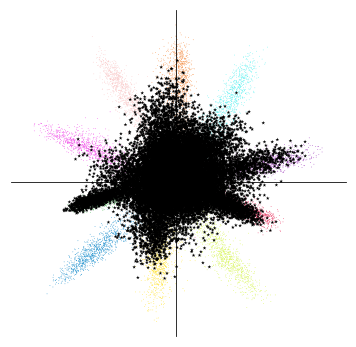

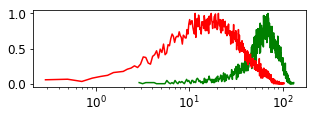

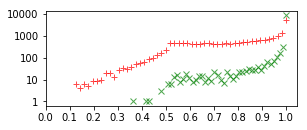

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Vanilla_0_Not_MNIST.txt


In [11]:
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}')

##### Network Trained with Letters as Background Class

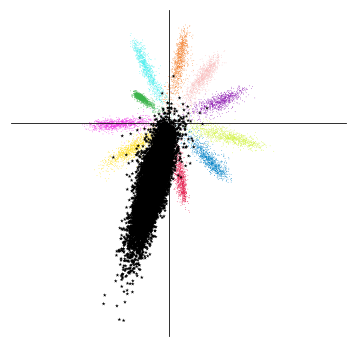

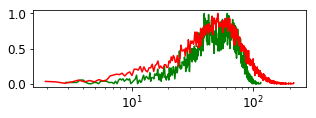

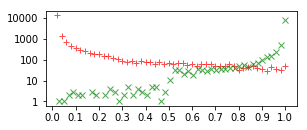

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_BG_0_Not_MNIST.txt


In [12]:
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}')

##### Entropic OpenSet

Raw MNIST trained with Letters Samples as negatives (CrossEntropy Label for negatives = 0.1)

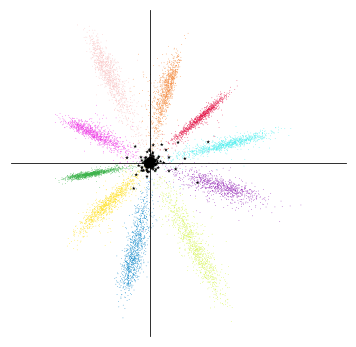

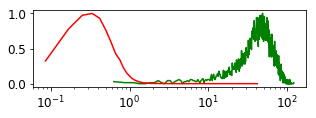

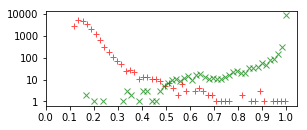

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Cross_0_Not_MNIST.txt


In [13]:
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}')

##### ObjectoSphere Loss

##### Prerequisites for Testing Objectosphere

In [14]:
from keras.layers import Input

In [15]:
Minimum_mag_for_knowns=50.

In [16]:
def ring_loss(y_true,y_pred):
    pred=K.sqrt(K.sum(K.square(y_pred),axis=1))
    error=K.mean(K.square(
        # Loss for Knowns having magnitude greater than knownsMinimumMag
        y_true[:,0]*(K.maximum(knownsMinimumMag-pred,0.))
        # Add two losses
        +
        # Loss for unKnowns having magnitude greater than unknownsMaximumMag
        y_true[:,1]*(pred)
    ))
    return error
X_train,Y_train,sample_weights,Y_pred_with_flags=model_tools.concatenate_training_data(mnist,letters.X_train,0.1,ring_loss=True)
knownsMinimumMag = Input((1,), dtype='float32', name='knownsMinimumMag')
knownsMinimumMag_ = np.ones((X_train.shape[0]))*Minimum_mag_for_knowns

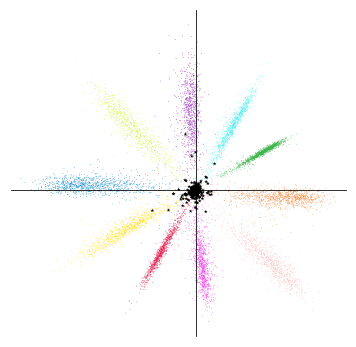

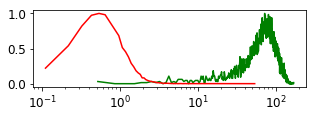

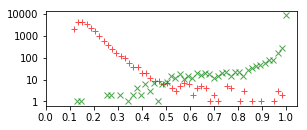

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Ring_50.0_0_Not_MNIST.txt


In [17]:
Ring_Loss_Lenet_pp = keras.models.load_model(('LeNet++/Models/Ring_{}_{}.h5py').format(Minimum_mag_for_knowns,random_model_no), custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,file_name=dataset_type+'/Ring_'+str(Minimum_mag_for_knowns)+'_'+random_model_no+'_{}.{}')

Plotting


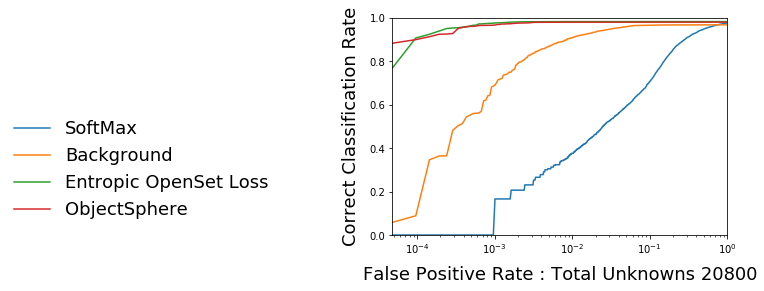

In [18]:
evaluation_plotter(dataset_type,'0')

#### Testing with other Random Model Weight Initialization

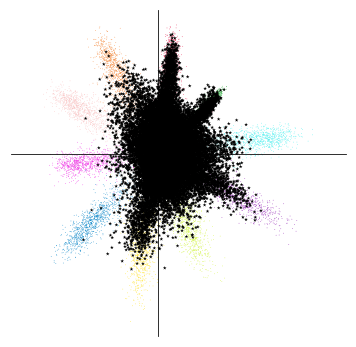

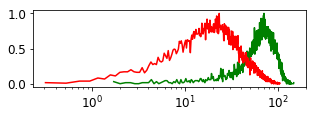

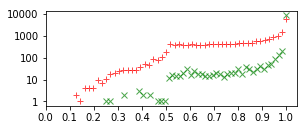

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Vanilla_1_Not_MNIST.txt


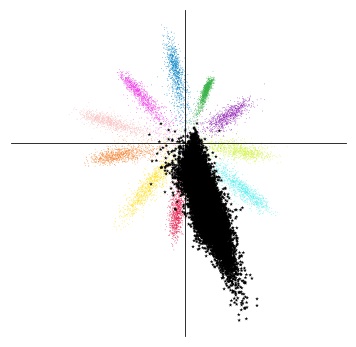

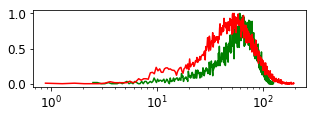

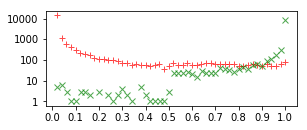

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_BG_1_Not_MNIST.txt


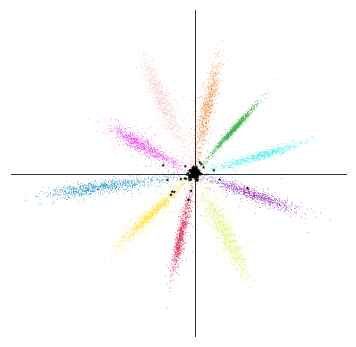

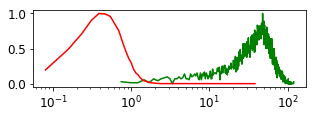

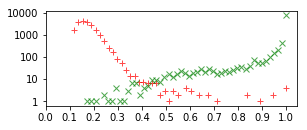

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Cross_1_Not_MNIST.txt


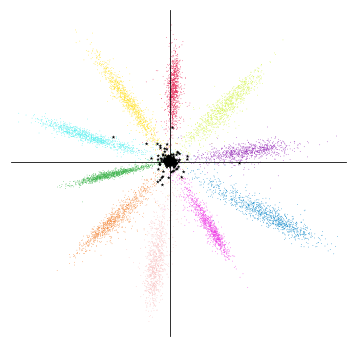

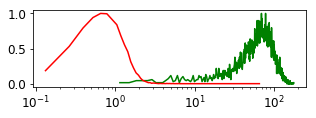

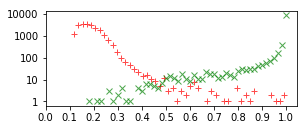

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Ring_50.0_1_Not_MNIST.txt


In [19]:
random_model_no='1'
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}')
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}')
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}')
Ring_Loss_Lenet_pp = keras.models.load_model(('LeNet++/Models/Ring_{}_{}.h5py').format(Minimum_mag_for_knowns,random_model_no), custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,file_name=dataset_type+'/Ring_'+str(Minimum_mag_for_knowns)+'_'+random_model_no+'_{}.{}')

Plotting


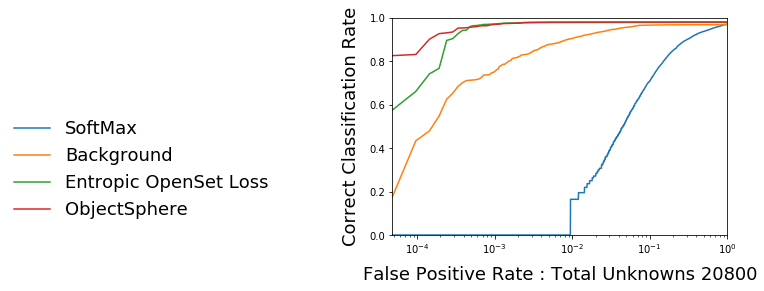

In [20]:
evaluation_plotter(dataset_type,'1')

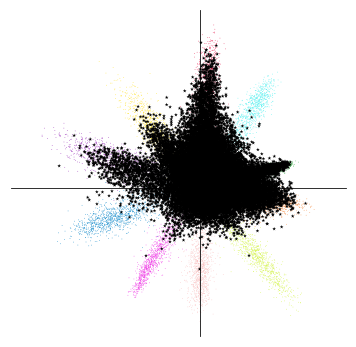

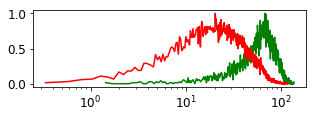

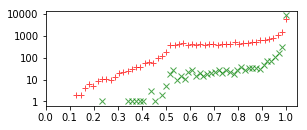

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Vanilla_2_Not_MNIST.txt


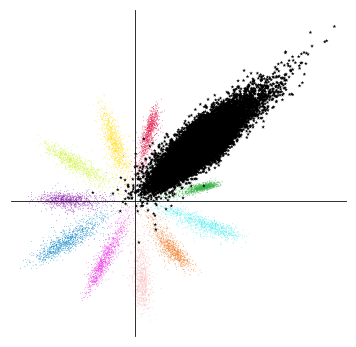

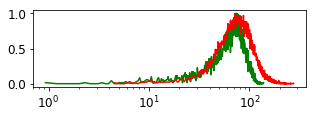

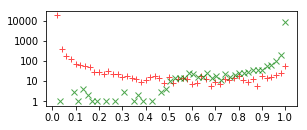

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_BG_2_Not_MNIST.txt


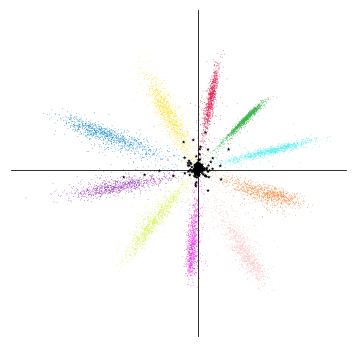

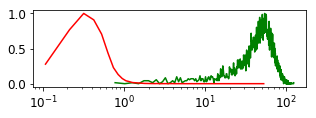

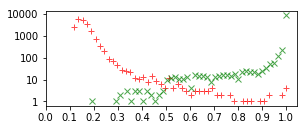

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Cross_2_Not_MNIST.txt


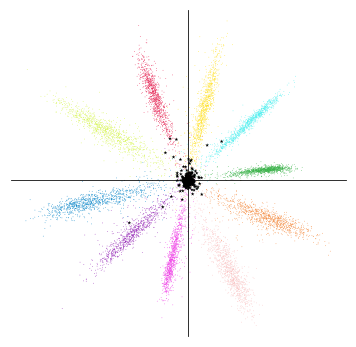

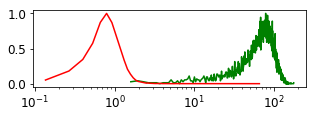

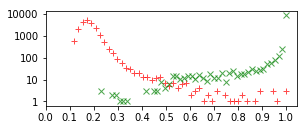

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Ring_50.0_2_Not_MNIST.txt


In [21]:
random_model_no='2'
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}')
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}')
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}')
Ring_Loss_Lenet_pp = keras.models.load_model(('LeNet++/Models/Ring_{}_{}.h5py').format(Minimum_mag_for_knowns,random_model_no), custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,file_name=dataset_type+'/Ring_'+str(Minimum_mag_for_knowns)+'_'+random_model_no+'_{}.{}')

Plotting


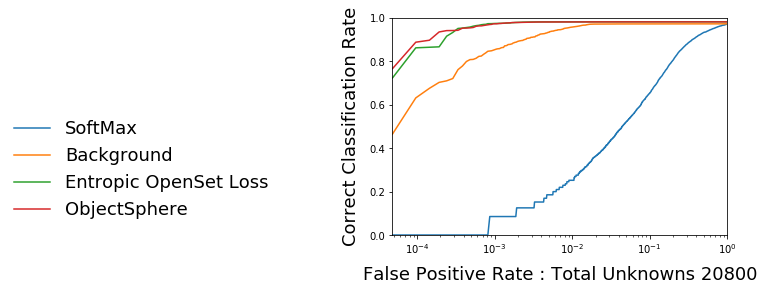

In [22]:
evaluation_plotter(dataset_type,'2')

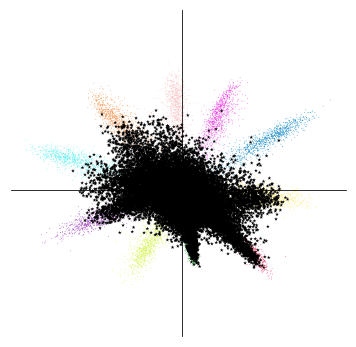

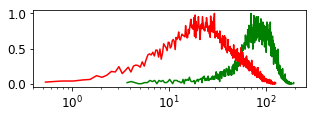

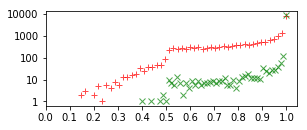

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Vanilla_3_Not_MNIST.txt


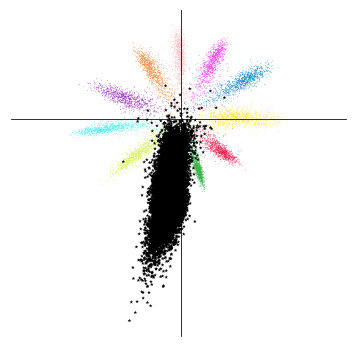

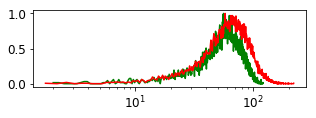

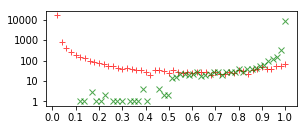

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_BG_3_Not_MNIST.txt


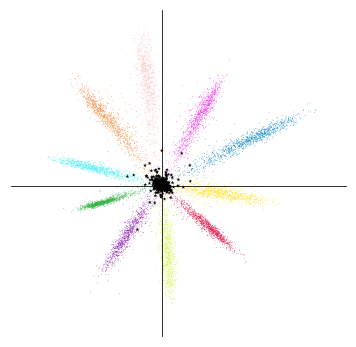

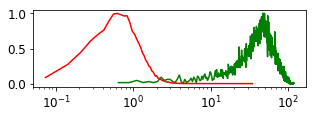

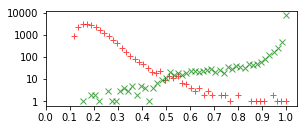

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Cross_3_Not_MNIST.txt


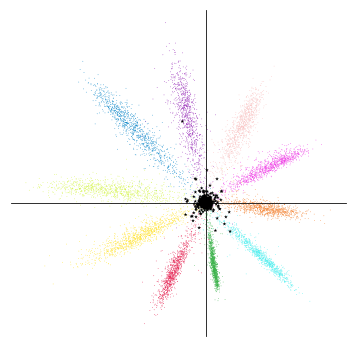

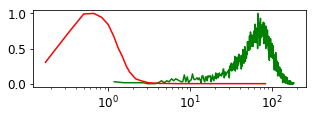

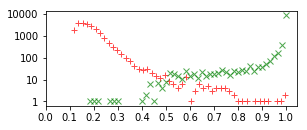

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Ring_50.0_3_Not_MNIST.txt


In [23]:
random_model_no='3'
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}')
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}')
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}')
Ring_Loss_Lenet_pp = keras.models.load_model(('LeNet++/Models/Ring_{}_{}.h5py').format(Minimum_mag_for_knowns,random_model_no), custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,file_name=dataset_type+'/Ring_'+str(Minimum_mag_for_knowns)+'_'+random_model_no+'_{}.{}')

Plotting


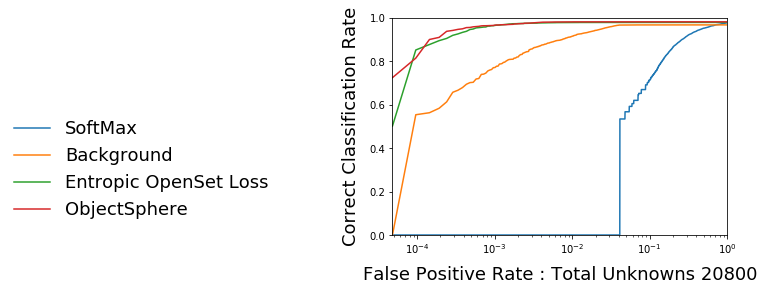

In [24]:
evaluation_plotter(dataset_type,'3')

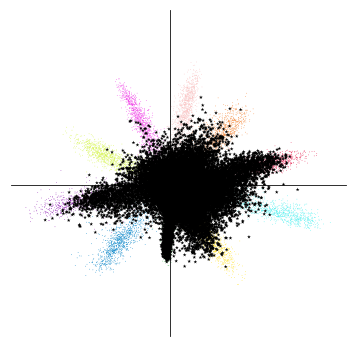

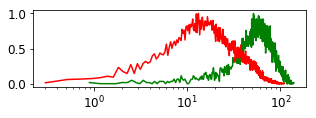

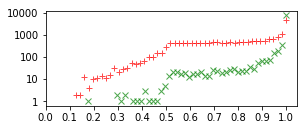

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Vanilla_4_Not_MNIST.txt


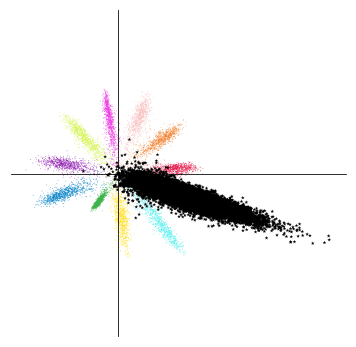

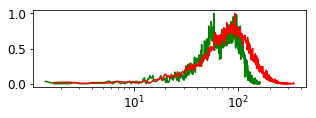

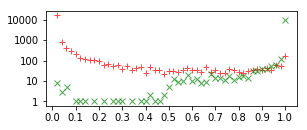

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_BG_4_Not_MNIST.txt


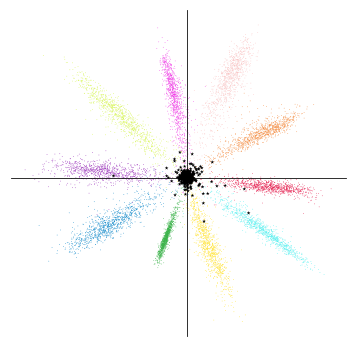

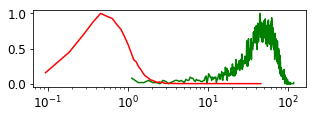

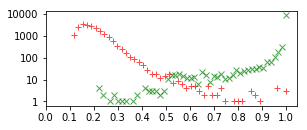

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Cross_4_Not_MNIST.txt


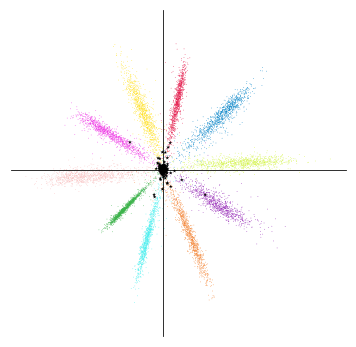

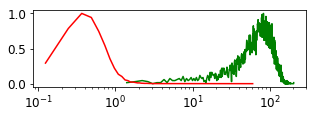

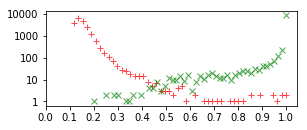

DIR score file saved at LeNet++/DIRs/Not_MNIST/Multiplying_with_mag_Ring_50.0_4_Not_MNIST.txt


In [25]:
random_model_no='4'
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}')
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}')
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}')
Ring_Loss_Lenet_pp = keras.models.load_model(('LeNet++/Models/Ring_{}_{}.h5py').format(Minimum_mag_for_knowns,random_model_no), custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,file_name=dataset_type+'/Ring_'+str(Minimum_mag_for_knowns)+'_'+random_model_no+'_{}.{}')

Plotting


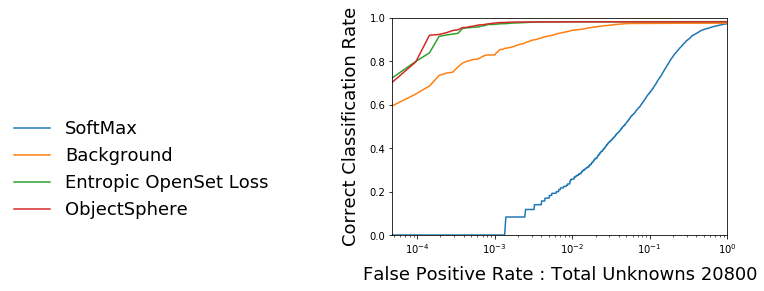

In [26]:
evaluation_plotter(dataset_type,'4')

### Comparision with CIFAR

Loading Dataset

In [27]:
cifar=data_prep.cifar_prep()

In [28]:
dataset_type='CIFAR'
random_model_no='0'
if not os.path.exists('LeNet++/Final_Plots/'+dataset_type):
    os.makedirs('LeNet++/Final_Plots/'+dataset_type)
if not os.path.exists('LeNet++/DIRs/'+dataset_type):
    os.makedirs('LeNet++/DIRs/'+dataset_type)

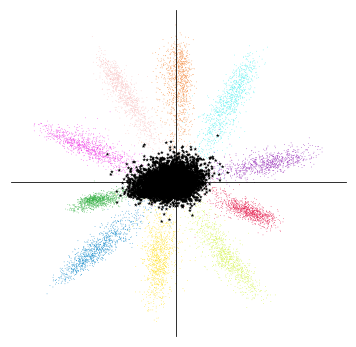

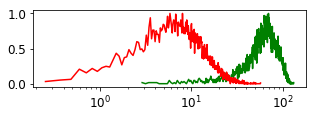

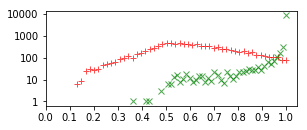

DIR score file saved at LeNet++/DIRs/CIFAR/Multiplying_with_mag_Vanilla_0_CIFAR.txt


In [29]:
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,neg=cifar.images,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

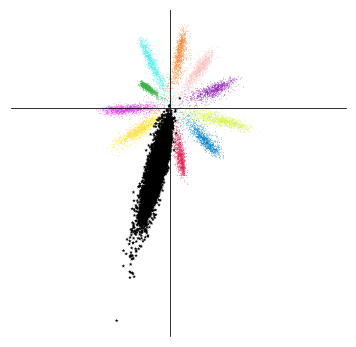

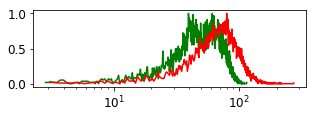

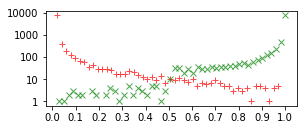

DIR score file saved at LeNet++/DIRs/CIFAR/Multiplying_with_mag_BG_0_CIFAR.txt


In [30]:
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,neg=cifar.images,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

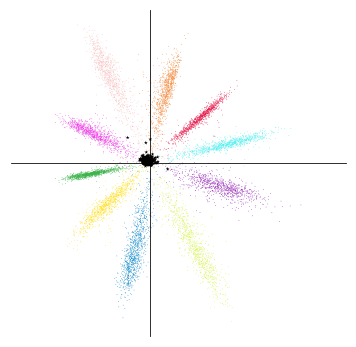

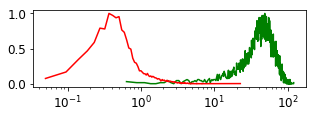

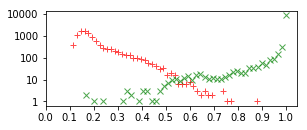

DIR score file saved at LeNet++/DIRs/CIFAR/Multiplying_with_mag_Cross_0_CIFAR.txt


In [31]:
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,neg=cifar.images,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

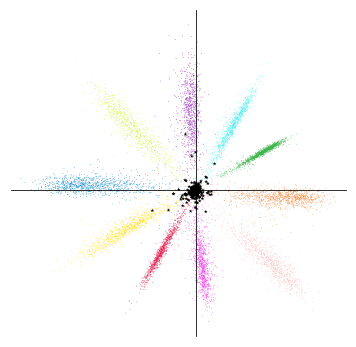

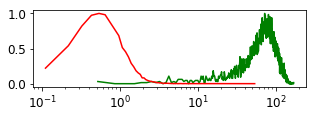

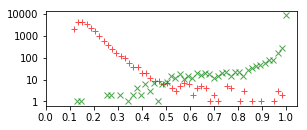

DIR score file saved at LeNet++/DIRs/CIFAR/Multiplying_with_mag_Ring_50.0_0_CIFAR.txt


In [32]:
Ring_Loss_Lenet_pp = keras.models.load_model(('LeNet++/Models/Ring_{}_{}.h5py').format(Minimum_mag_for_knowns,random_model_no), custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,file_name=dataset_type+'/Ring_'+str(Minimum_mag_for_knowns)+'_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

Plotting


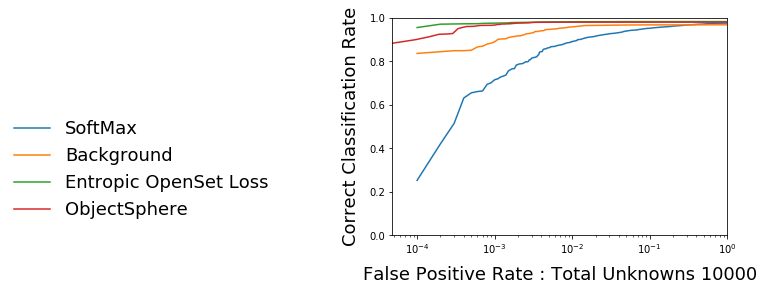

In [33]:
evaluation_plotter(dataset_type,'0')

### Comparision On Known Unknown Letters

In [34]:
random_model_no='0'
dataset_type='Letters_Known_Unknowns'
if not os.path.exists('LeNet++/Final_Plots/'+dataset_type):
    os.makedirs('LeNet++/Final_Plots/'+dataset_type)
if not os.path.exists('LeNet++/DIRs/'+dataset_type):
    os.makedirs('LeNet++/DIRs/'+dataset_type)

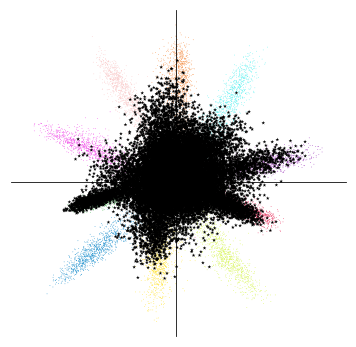

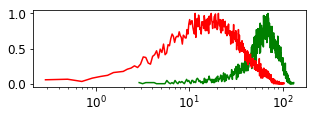

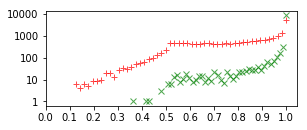

DIR score file saved at LeNet++/DIRs/Letters_Known_Unknowns/Multiplying_with_mag_Vanilla_0_Letters_Known_Unknowns.txt


In [35]:
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,neg=letters.X_test,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

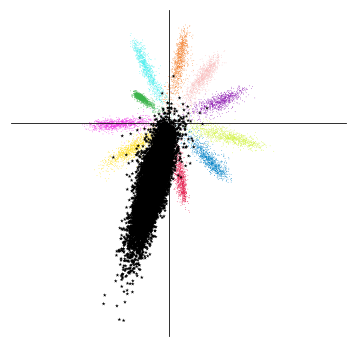

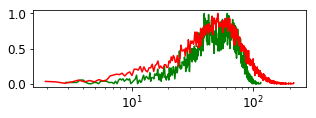

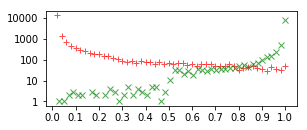

DIR score file saved at LeNet++/DIRs/Letters_Known_Unknowns/Multiplying_with_mag_BG_0_Letters_Known_Unknowns.txt


In [36]:
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,neg=letters.X_test,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

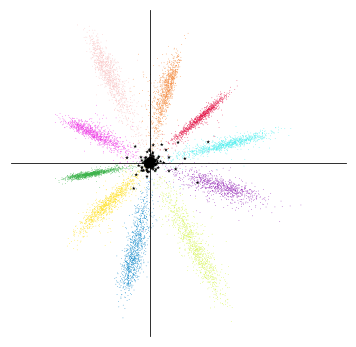

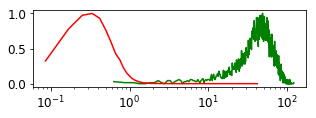

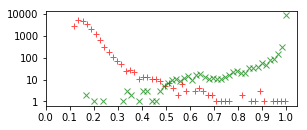

DIR score file saved at LeNet++/DIRs/Letters_Known_Unknowns/Multiplying_with_mag_Cross_0_Letters_Known_Unknowns.txt


In [37]:
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,neg=letters.X_test,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

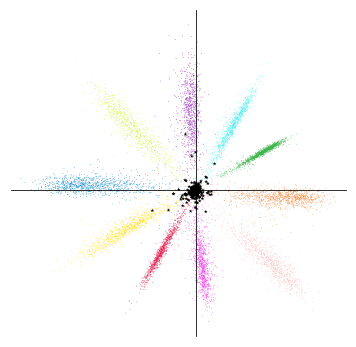

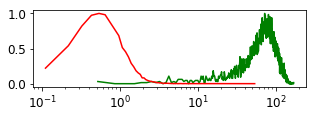

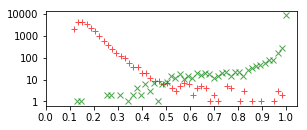

DIR score file saved at LeNet++/DIRs/Letters_Known_Unknowns/Multiplying_with_mag_Ring_50.0_0_Letters_Known_Unknowns.txt


In [38]:
Ring_Loss_Lenet_pp = keras.models.load_model(('LeNet++/Models/Ring_{}_{}.h5py').format(Minimum_mag_for_knowns,random_model_no), custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,file_name=dataset_type+'/Ring_'+str(Minimum_mag_for_knowns)+'_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

Plotting


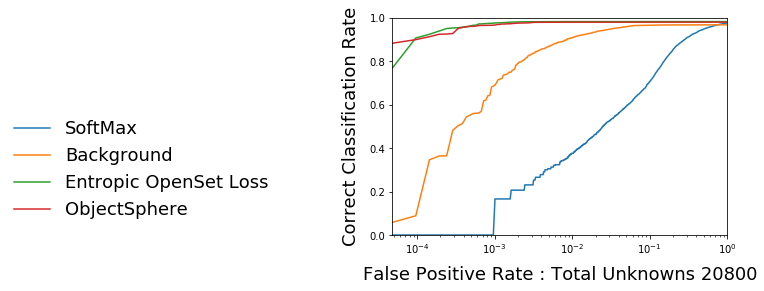

In [39]:
evaluation_plotter(dataset_type,'0')

### Comparision On Devanagari

Loading Dataset

In [40]:
hindi=data_prep.hindi_letters()

In [41]:
random_model_no='0'
dataset_type='Devanagari'
if not os.path.exists('LeNet++/Final_Plots/'+dataset_type):
    os.makedirs('LeNet++/Final_Plots/'+dataset_type)
if not os.path.exists('LeNet++/DIRs/'+dataset_type):
    os.makedirs('LeNet++/DIRs/'+dataset_type)

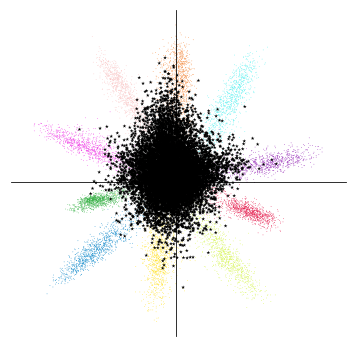

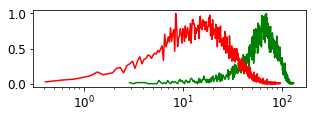

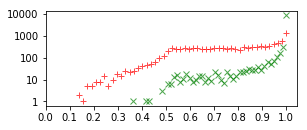

DIR score file saved at LeNet++/DIRs/Devanagari/Multiplying_with_mag_Vanilla_0_Devanagari.txt


In [42]:
vanilla_lenet_pp=keras.models.load_model('LeNet++/Models/Vanilla_'+random_model_no+'.h5py')
analyze(vanilla_lenet_pp,neg=hindi.images,file_name=dataset_type+'/Vanilla_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

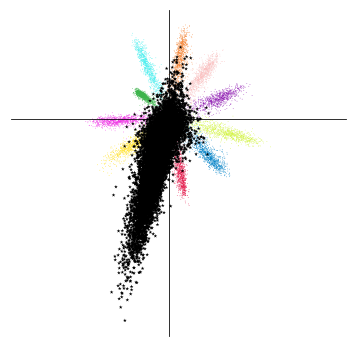

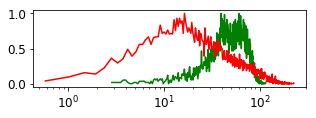

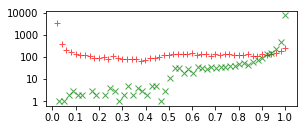

DIR score file saved at LeNet++/DIRs/Devanagari/Multiplying_with_mag_BG_0_Devanagari.txt


In [43]:
BG=keras.models.load_model('LeNet++/Models/BG_'+random_model_no+'.h5py')
analyze(BG,neg=hindi.images,file_name=dataset_type+'/BG_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

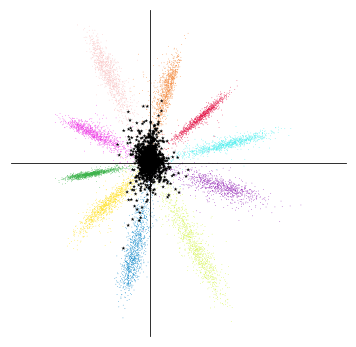

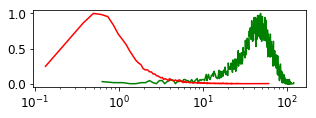

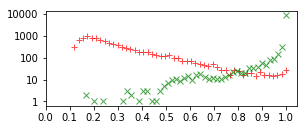

DIR score file saved at LeNet++/DIRs/Devanagari/Multiplying_with_mag_Cross_0_Devanagari.txt


In [44]:
negative_training_lenet_pp=keras.models.load_model('LeNet++/Models/Cross_'+random_model_no+'.h5py')
analyze(negative_training_lenet_pp,neg=hindi.images,file_name=dataset_type+'/Cross_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

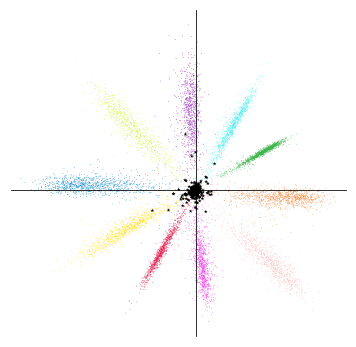

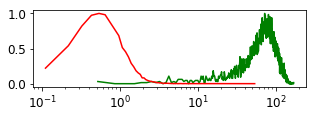

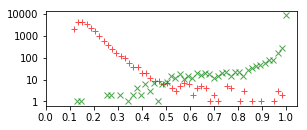

DIR score file saved at LeNet++/DIRs/Devanagari/Multiplying_with_mag_Ring_50.0_0_Devanagari.txt


In [45]:
Ring_Loss_Lenet_pp = keras.models.load_model(('LeNet++/Models/Ring_{}_{}.h5py').format(Minimum_mag_for_knowns,random_model_no), custom_objects={'ring_loss': ring_loss})
analyze(Ring_Loss_Lenet_pp,file_name=dataset_type+'/Ring_'+str(Minimum_mag_for_knowns)+'_'+random_model_no+'_{}.{}',neg_labels=dataset_type)

Plotting


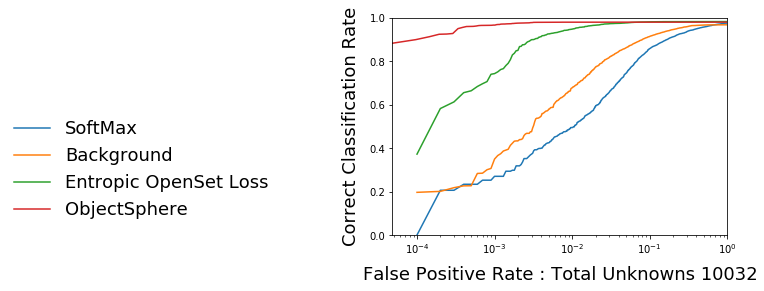

In [46]:
evaluation_plotter(dataset_type,'0')